# Homework 4 - Costa Rica Poverty Classification

This dataset was placed on Kaggle by the Inter-American Development Bank as part of their project to try to improve methods of identifying individuals who are in poverty, and who therefore would most benefit from aid efforts. 

Below is my intended "gameplan":
1. Read in data.
2. Use exploratory analysis and some visualizations to get a better feel for the data
3. Do some cleaning, filling in missing data, etc.
    * This dataset has some interesting components to it, and I will be using information from the Kaggle competition and other Kaggle kernels to get a better feel for how to handle these issues.
4. Try out a few different models (using 10-fold cross-validation each time)
    * Logistic regression
    * K-Nearest Neighbors
    * SVM
    * Decision Tree (just for kicks, it'll be overly simplistic for sure)
    * Random Forest
5. After picking the best performing model, tweak with the hyperparameters using either a gridsearch or random search.
6. Pick the best one to submit to Kaggle!

### Notes on Resources Used:
* Data: [Kaggle Costa Rican Household Poverty Level Prediction](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data)
* Extra Resources:
    * [Will Koehrsen's 'A Complete Introduction and Walkthrough' Kernel on Kaggle](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough) - I consulted with one of the highest rated kernels on this project, which was created by Will Koehrsen, and is basically a tutorial for how to approach the problem. I do not do nearly as much as he does, but it was a very useful resource for code and the type of questions that are useful to ask to solve this problem.
        * For the sake of transparency, I will mark most large blocks of code directly copied from his kernel with a "WK" in a comment above the code block
    * [Nelson's Homework 4 from a Previous Semester](https://github.com/ngriffiths13/Applied_Machine_Learning_Classwork/blob/master/Homeworks/HW4/Homework%204%20-%20Costa%20Rica%20Poverty%20Classification.ipynb) - Nelson showed us his past homework in class, specifically to show us how to approach dealing with unbalanced classes in a classification setting using oversampling. I used his homework to help with implementing oversampling, and also as an overall resource for code and how to approach the problem.
        * Again, I will try to mark large blocks of code that I copied from Nelson with a "NG" comment above the code. Note, however, that lots of things that I borrowed are modifications of or inspired by code that I saw on Nelson's or Will's documents, and not necessarily straight copy-paste.

In [1]:
# Modified from NG
# Data libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('fivethirtyeight')
five_thirty_eight = ["#30a2da","#fc4f30","#e5ae38","#6d904f","#8b8b8b",]
sns.set_palette(five_thirty_eight)
%matplotlib inline

# Silence deprecation warnings
import warnings
warnings.filterwarnings("ignore")

# Modeling, validation, and other SKLearn modules
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_curve, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Oversampling
from imblearn.over_sampling import RandomOverSampler

### Read in Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
pd.options.display.max_columns = 150
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
ntrain = train.shape[0]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


We can see above the first few rows of data, as well as all of the column names. Looking at the summary information, we can see that there are 143 columns, with 130 being integers (either Boolean or discrete), 8 floats, and 5 objects. Eventually, the 5 objects will need to be converted to dummy variables in order to run the model.

Next, let's look at the test set.

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Right away, we can see that the test set actually has significantly more individuals in it than the training set (23,856 vs. 9557). We can also see that it has exactly one less column, which is to be expected, since we are trying to predict the "Target" column, which represents the degree to which a given household experiences poverty. We will have to come back to this, because some of the labels don't match exactly as they should.

For now, let's try and figure out how much of our integer data is binary or discrete (aka ordinal).

### Exploratory Analysis and Visualization (with some cleaning along the way)

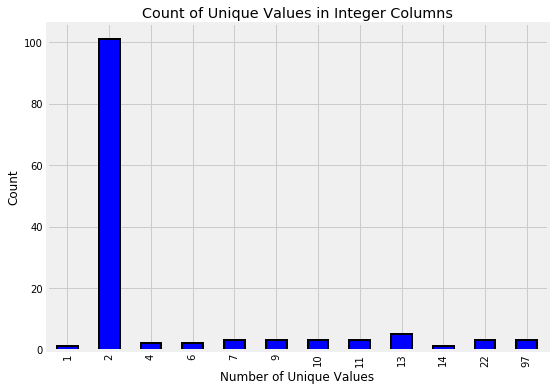

In [6]:
# WK
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
figsize = (8, 6), edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

As we can see, the vast majority of the integer columns have only 2 unique values, which means that these are binary values.

Let's take a look now at the object columns.

In [7]:
train.select_dtypes('object').head(10)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no
5,ID_ec05b1a7b,2b58d945f,yes,11,no
6,ID_e9e0c1100,2b58d945f,yes,11,no
7,ID_3e04e571e,d6dae86b7,yes,9,no
8,ID_1284f8aad,d6dae86b7,yes,9,no
9,ID_51f52fdd2,d6dae86b7,yes,9,no


We can look at what each of these columns represents in the data description:

* Id - This is the individual ID number
* idhogar - This ID number identifies individuals that belong to the same household, and we need to make sure that their target matches up with the target of their head of household, because that is what the scoring will be based on in the Kaggle competition.
* dependency - From the Kaggle description: "Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)"
* edjefe - From Kaggle: "years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0"
* edjefa - From Kaggle: "years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0"

So, from what we can see, the first two make sense to be a mix of strings and numbers in order to distinguish each individual and household. The last three, however, appear to have the values for 0 and 1 (which actually make sense in the context of number of dependents or years of education) changed to either "yes" or "no". So, we will need to change these to numbers before we will be able to fit the data to a model.

In [8]:
# WK
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


Now those columns are correct in both the train and test sets, and makes sense for the problem. The last two object variables (Id and idhogar) will be dropped before modelling, so we should be good to go on the categorical variable front.

Before we move forward with any further cleaning or fixing for missing values and such, I'm going to join the training and test dataframes so that we do the same things to all of the data. We can separate them out later by looking at the value for "Target".

In [9]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

In [10]:
data.shape

(33413, 143)

Now our data is all in one dataframe, and we can fix these problems in both sets at the same time.

Next, let's try and figure out how many households don't match the poverty label of the head of their household, and then we can fix it.

In [11]:
# WK
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print(f'{len(not_equal)} households have members with poverty labels that don\'t match the head of household.')

85 households have members with poverty labels that don't match the head of household.


So there are 85 households that don't match across members of the household. We can correct for this mislabelling for households that don't match and have a head (the households without a head don't mismatch, and won't be used for scoring anyway).

In [12]:
# WK
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(data[(data['idhogar'] == household) & (data['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    data.loc[data['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = data.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print(f'{len(not_equal)} households have members with poverty labels that don\'t match the head of household.')

7352 households have members with poverty labels that don't match the head of household.


Now, it appears that the number jumped up instead of going completely away, but this is because the first time I printed the mismatches, it was only on the training data within the whole dataset, and this second one includes the null values for the test set. The null values don't show to be matching within the same household, but by comparing the 7352 households identified with the number of unique households in the testing set, we can show that we did correctly fix the households in the training set that were mismatched.

In [13]:
test.idhogar.nunique()

7352

Yes! The numbers are exactly the same, so we correctly fixed the problem.

Let's move on now to look at the missing values in the dataset. Let's do this by looking at the percentage of each column that is missing.

In [14]:
# WK
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


Not too bad. We can see here that only 5 of the columns have any missing data (we dropped the Target column because we purposefully created the missing values there). Let's look at the individual columns and try and figure out how best to handle each of the missing values. We'll look at them a little out of order, fixing the easier ones first.

#### v18q1
The Kaggle data description lists this column as "number of tablets household owns".  There is also a column that is a dummy variable v18q, which is if a household owns a tablet". We can check and see if the number of missing values here is the same as the 0 condition for owning a tablet.

In [15]:
data.v18q.value_counts()

0    25468
1     7945
Name: v18q, dtype: int64

As we can see, the number of people identified as not owning a tablet perfectly matches the number of missing values in v18q1, so we can replace those nulls with zeros.

In [16]:
data['v18q1'] = data['v18q1'].fillna(0)

#### v2a1
This next column is identified as "Monthly rent payment". Like before, there might be a good reason why these values are missing, such as because certain groups of people didn't have a monthly rent payment. We actually have groups of data on ownership/rental status of a household, so we can take a look at the distribution of missing rent payments based on that.

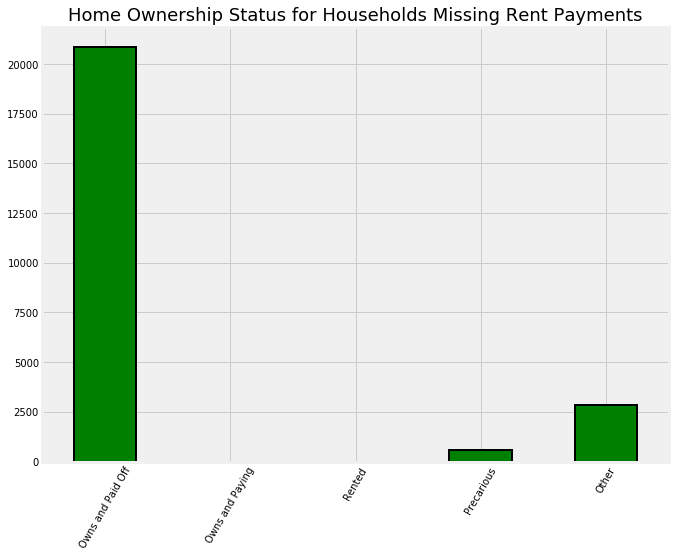

In [17]:
# WK
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

As we can see here, the vast majority of missing data comes from households that own and have already paid off their home, and so we can replace those missing values with zeros. For the others, it is hard to figure out exactly why the values are missing, and so we can impute values for them as well as add in an extra dummy variable that indicates that there was missing data for those values.

In [18]:
# WK
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

# NG
#Fill in remaining missing values with median only using training data from head of households
data['v2a1'] = data.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

#### rez_esc
This is the column that had the most missing data of any feature. The Kaggle data description identifies this as "Years behind in school". The Kaggle discussions about this talked about how data was not included for anyone outside the age range 7 to 18, so we can safely impute a zero for anyone outside that range. For those within the school range, we can replace the missing values with the median and put in an extra dummy variable for those that had missing, since we can't be entirely sure why these values are missing.

In [19]:
# NG
#We assume anyone not between the age of 7 and 17 is not in school and thus this doesnt apply to them.
data.loc[((data['age'] >= 18) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

#For those in school we flag them as missing values.
data['missing_rez_esc'] = 0
data.loc[(data.rez_esc.isnull()), 'missing_rez_esc'] = 1

#Now we are going to impute the rest of our missing values after grouping them by age and years in school
#This should give us a good idea of if they should be years behind.
data['rez_esc'] = data.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))

#### SQBmeaned	and meaneduc
The last two variables with any missed values are SQBmeaned	and meaneduc, which are related to each other, and only about a tenth of a percent of the values are missing, so it seems reasonable to impute these with the median value. Even if there is some strong reason not to impute values here, it shouldn't affect the overall data very much.

In [20]:
# NG
data['meaneduc'] = data.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))
data['SQBmeaned'] = (data.meaneduc)**2

Now that we have cleaned up and imputed missing values, we can separate our data back into its training and test sets.

In [61]:
train_cleaned = data[:ntrain]
X = train_cleaned.drop('idhogar', axis=1)
X_id = X['Id']
X = X.drop('Id', axis=1)
y = X['Target']
X = X.drop('Target', axis=1)

test_cleaned = data[ntrain:]
test_cleaned = test_cleaned.drop('idhogar', axis=1)
test_ID = test_cleaned['Id']
test_cleaned = test_cleaned.drop('Id', axis=1)
test_cleaned = test_cleaned.drop('Target', axis=1)
test_cleaned.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 9557 to 33412
Columns: 142 entries, v2a1 to missing_rez_esc
dtypes: bool(1), float64(11), int64(130)
memory usage: 25.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 142 entries, v2a1 to missing_rez_esc
dtypes: bool(1), float64(11), int64(130)
memory usage: 10.3 MB


In [28]:
X.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,v2a1-missing,missing_rez_esc
0,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.0,10.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,False,0
1,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,8.0,12.0,0.0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,False,0
2,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,8.0,0.0,11.0,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,False,0
3,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,False,0
4,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,False,0


In [35]:
X.columns[X.isnull().any()]

Index([], dtype='object')

In [36]:
train_cleaned.columns[train_cleaned.isnull().any()]

Index([], dtype='object')

Huzzah! We can see that there is no missing data in either our training or testing sets! We can finally move on to doing some modeling.

### Modeling
At the very beginning of this notebook, I outlined in my "gameplan" which models I wanted to try to use to solve this problem. Now, we will finally get to do some of that.

In [40]:
# Split our training data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = .2, random_state=42)

In [38]:
# NG
# Note that we are going to initially try out each of the classifiers on the whole training set before we try to tune
# or compare with the validation set we designated above
def test_clf(clf):
    score = cross_val_score(clf, X, y, scoring = 'f1_macro', cv = 10)
    print(clf.__class__.__name__,"Score =", score.mean())

In [39]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

models = [lr, knn, svc, dt, rf]
for clf in models:
    test_clf(clf)

LogisticRegression Score = 0.32595976804153926
KNeighborsClassifier Score = 0.3296930234626868
SVC Score = 0.21517746897320963
DecisionTreeClassifier Score = 0.32019152777150406
RandomForestClassifier Score = 0.3666998027057819


So, after running all of those, the Random Forest came out on top (surprise, surprise). It was interesting to me that the SVC took the longest of all of them to run (nearly five minutes), but had the worst score. We will move forward with tuning the Random Forest, and see how far we can get.

(Save in case I have to run things again: SVC Score = 0.21517746897320963)

#### Note: It was at this point that I realized that I did not scale my data prior to running any of these classifiers, and that scaling would probably improve performance. However, with the limited amount of time that I have left before the assignment is due, I am going to press forward, and note that scaling would be a valuable thing to do before trying all the other tuning parameters.

In [41]:
y_train.value_counts()

4.0    4820
2.0    1256
3.0     964
1.0     605
Name: Target, dtype: int64

As shown above, our dataset is quite unbalanced across the different classes (remember that this is "poverty level", one being severe, 4 being "non-vulnerable). So, instead of including both balanced and unbalanced as hyperparameters in the GridSearch, I am going to save time by assuming that using the "balanced" will always be better.

In [42]:
param_dictionary = {"n_estimators": [100, 500, 1000], "max_depth": [1,2,3,5,10]}
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
gs = GridSearchCV(clf, param_dictionary, scoring='f1_macro', n_jobs=-1, verbose=2, cv=10)
gs.fit(x_tr, y_tr)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.7s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000], 'max_depth': [1, 2, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=2)

In [43]:
gs.best_params_

{'max_depth': 10, 'n_estimators': 1000}

So, from what we can see, the best choice was 1000 estimators and a max depth of 10. Since both of these were on the limit of the hyperparameters tested, there could probably be improvement by increasing them. However, before doing so, we need to check and see what our score is on the training and test groups, and see if we are overfitting. Let's check our score on the training group first.

In [46]:
train_predictions = gs.predict(x_tr)
cr = classification_report(y_tr, train_predictions)
f1_trained_score = f1_score(y_tr, train_predictions, average = 'macro')
print("Training Scores:")
print(cr)
print("-"*50)
print(f"F1 Score: {f1_trained_score}")

Training Scores:
              precision    recall  f1-score   support

         1.0       0.87      0.96      0.92       484
         2.0       0.82      0.93      0.87       992
         3.0       0.79      0.95      0.86       768
         4.0       0.97      0.89      0.93      3872

   micro avg       0.91      0.91      0.91      6116
   macro avg       0.86      0.93      0.89      6116
weighted avg       0.92      0.91      0.91      6116

--------------------------------------------------
F1 Score: 0.8948242662681524


Nice! Our F1 is fantastic, at 0.89! Then, after we get too overexcited, we can take a look at the leaderboard and see that the number 1 spot has a macro F1-score of 0.44878. In our exuberance, we forgot that this score is for the training set only, and not on the testing set. Let's prepare ourselves for disappointment, and check on the validation set.

In [50]:
val_predictions = gs.predict(x_val)
cr = classification_report(y_val, val_predictions)
f1_trained_score = f1_score(y_val, val_predictions, average = 'macro')
print("Testing Scores:")
print(cr)
print("-"*50)
print(f"F1 Score: {f1_trained_score}")

Training Scores:
              precision    recall  f1-score   support

         1.0       0.72      0.82      0.76       121
         2.0       0.73      0.77      0.75       264
         3.0       0.65      0.77      0.70       196
         4.0       0.92      0.86      0.89       948

   micro avg       0.83      0.83      0.83      1529
   macro avg       0.75      0.80      0.78      1529
weighted avg       0.84      0.83      0.83      1529

--------------------------------------------------
F1 Score: 0.77614190474771


You know, that's not as bad as I was expecting. An F1 of 0.776 on the validation set, when compared to a 0.8948 on training, isn't as bad as I thought it would be. Are we running into an overfitting problem? Yes, for sure, but it's not like we aren't able to predict anything at all on the validation set. In fact, it is better than what Kaggle is showing. Now, I'm fairly certain that my fairly simplistic Random Forest isn't outperforming the boosted trees on the leaderboard, so there is likely something different with the scoring that I'm not quite seeing. Before I try and submit my guesses to see my real score, though, I'm going to try to see what I can do about the overfitting.

Since max depth is something that allows for decision trees to easily overfit, I am going to purposefully decrease the max depth and see what macro f1 comparisons we get.

In [55]:
param_dictionary = {"max_depth": [5]}
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced', random_state=42)
gs = GridSearchCV(clf, param_dictionary, scoring='f1_macro', n_jobs=-1, verbose=2, cv=10)
gs.fit(x_tr, y_tr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.4s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5]}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring='f1_macro', verbose=2)

In [56]:
train_predictions = gs.predict(x_tr)
cr = classification_report(y_tr, train_predictions)
f1_trained_score = f1_score(y_tr, train_predictions, average = 'macro')
print("Training Scores:")
print(cr)
print("-"*50)
print(f"F1 Score: {f1_trained_score}")

Training Scores:
              precision    recall  f1-score   support

         1.0       0.44      0.71      0.54       484
         2.0       0.54      0.52      0.53       992
         3.0       0.35      0.58      0.44       768
         4.0       0.90      0.72      0.80      3872

   micro avg       0.67      0.67      0.67      6116
   macro avg       0.56      0.63      0.58      6116
weighted avg       0.73      0.67      0.69      6116

--------------------------------------------------
F1 Score: 0.5760523992895172


In [57]:
val_predictions = gs.predict(x_val)
cr = classification_report(y_val, val_predictions)
f1_trained_score = f1_score(y_val, val_predictions, average = 'macro')
print("Testing Scores:")
print(cr)
print("-"*50)
print(f"F1 Score: {f1_trained_score}")

Testing Scores:
              precision    recall  f1-score   support

         1.0       0.41      0.67      0.51       121
         2.0       0.53      0.51      0.52       264
         3.0       0.33      0.55      0.41       196
         4.0       0.89      0.70      0.78       948

   micro avg       0.65      0.65      0.65      1529
   macro avg       0.54      0.61      0.55      1529
weighted avg       0.72      0.65      0.67      1529

--------------------------------------------------
F1 Score: 0.5545628983630898


Wow, our F1 went way down, but our overfitting problem greatly decreased. However, the validation F1 on the previous model, even though there was overfitting going on, was quite a bit better than this one here. So the question is: do we care more about the overfitting (and consistency aross validation sets), or the possibility of a more-variable but better performing model?

Before I decide, I'm going to compare how each of them performs on the larger testing set that I haven't touched yet, and see which one does better.

In [58]:
val_predictions = gs.predict(X_test)
cr = classification_report(y_test, val_predictions)
f1_trained_score = f1_score(y_test, val_predictions, average = 'macro')
print("Testing Scores:")
print(cr)
print("-"*50)
print(f"F1 Score: {f1_trained_score}")

Testing Scores:
              precision    recall  f1-score   support

         1.0       0.45      0.68      0.54       169
         2.0       0.48      0.42      0.45       302
         3.0       0.32      0.52      0.40       257
         4.0       0.88      0.73      0.80      1184

   micro avg       0.65      0.65      0.65      1912
   macro avg       0.53      0.59      0.55      1912
weighted avg       0.71      0.65      0.67      1912

--------------------------------------------------
F1 Score: 0.5470523340826658


Wow, even on the larger test set, we see a consistent F1 of around .54. Now, I'll try the other model with more depth to see how it does.

In [59]:
param_dictionary = {"max_depth": [10]}
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced', random_state=42)
gs = GridSearchCV(clf, param_dictionary, scoring='f1_macro', n_jobs=-1, verbose=2, cv=10)
gs.fit(x_tr, y_tr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10]}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring='f1_macro', verbose=2)

In [60]:
val_predictions = gs.predict(X_test)
cr = classification_report(y_test, val_predictions)
f1_trained_score = f1_score(y_test, val_predictions, average = 'macro')
print("Testing Scores:")
print(cr)
print("-"*50)
print(f"F1 Score: {f1_trained_score}")

Testing Scores:
              precision    recall  f1-score   support

         1.0       0.78      0.82      0.80       169
         2.0       0.71      0.77      0.74       302
         3.0       0.69      0.75      0.72       257
         4.0       0.93      0.88      0.90      1184

   micro avg       0.84      0.84      0.84      1912
   macro avg       0.78      0.80      0.79      1912
weighted avg       0.85      0.84      0.84      1912

--------------------------------------------------
F1 Score: 0.7887681047743066


Well, we see that there is still a better performance on the larger testing set. For the purposes of this assignment, I am going to go with the more variable but better performing model, and we'll see how Kaggle says I did!

In [62]:
test_predictions = gs.predict(test_cleaned)

In [68]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_ID
kaggle_df['Target'] = test_predictions
kaggle_df.head()

,Id,Target
9557,ID_2f6873615,4.0
9558,ID_1c78846d2,4.0
9559,ID_e5442cf6a,4.0
9560,ID_a8db26a79,4.0
9561,ID_a62966799,4.0


In [69]:
kaggle_df.to_csv('Reid Empey - Costa Rica Poverty Classification Submition.csv', index=False)

Note: In the rush to submit, I ran into some errors and issues, but I will post to Slack what my score is once I get everything resolved.